In [14]:
# House Price Classification with EDA, Feature Engineering, and Evaluation
# 1. Import lib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
)

# 2.Load data
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [15]:
# 3. Feature Engineering
## 3.1 Drop Kolom dengan Missing Value Lebih dari 40%
missing_thresh = 0.4
missing_ratio = train_df.isnull().mean()
cols_to_drop = missing_ratio[missing_ratio > missing_thresh].index
train_df.drop(columns=cols_to_drop, inplace=True)
test_df.drop(columns=cols_to_drop, inplace=True)

## 3.2 Hapus Kolom ID
train_df.drop(columns=["Id"], inplace=True)
test_ids = test_df['Id']
test_df.drop(columns=["Id"], inplace=True)

## 3.3 Membuat Label Target: Mahal (> median) atau Murah
median_price = train_df["SalePrice"].median()
y = (train_df["SalePrice"] > median_price).astype(int)
X = train_df.drop(columns=["SalePrice"])

## 3.4 Mengisi Missing Value Sesuai Tipe Data
for col in X.columns:
    if X[col].dtype == 'object':
        X[col].fillna(X[col].mode()[0], inplace=True)
        if col in test_df.columns:
            test_df[col].fillna(X[col].mode()[0], inplace=True)
    else:
        X[col].fillna(X[col].median(), inplace=True)
        if col in test_df.columns:
            test_df[col].fillna(X[col].median(), inplace=True)

## 3.5 Label Encoding untuk Fitur Kategorikal
cat_cols = X.select_dtypes(include='object').columns
encoder = LabelEncoder()
for col in cat_cols:
    X[col] = encoder.fit_transform(X[col])
    if col in test_df.columns:
        test_df[col] = encoder.transform(test_df[col])

## 3.6 Scaling untuk Fitur Numerik
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
test_scaled = scaler.transform(test_df[X.columns])


<ipython-input-15-a9ac3ff34578>:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[col].fillna(X[col].median(), inplace=True)
<ipython-input-15-a9ac3ff34578>:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 

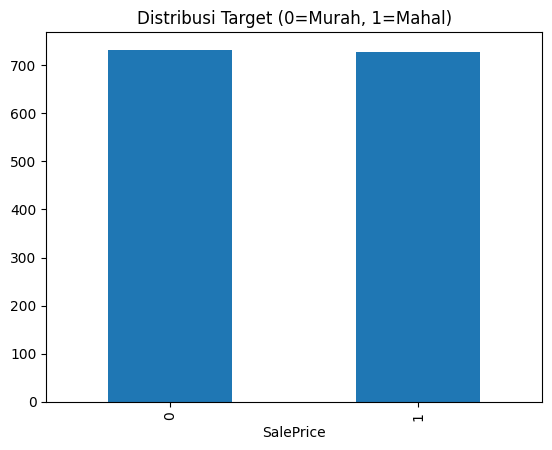

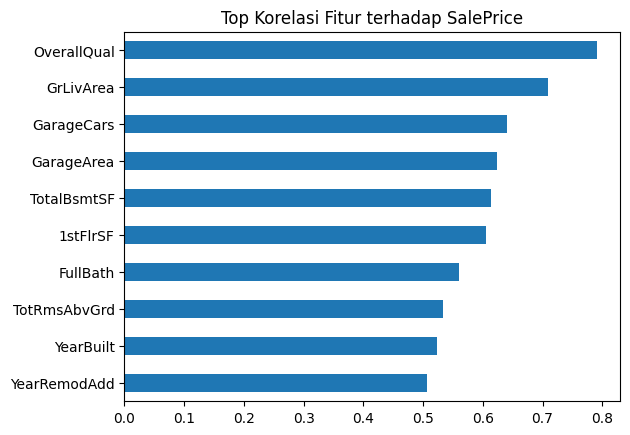

In [16]:
# 4. Exploratory Data Analysis (EDA)
## 4.1 Visualisasi Distribusi Target
y.value_counts().plot(kind='bar', title='Distribusi Target (0=Murah, 1=Mahal)')
plt.show()

## 4.2 Korelasi terhadap SalePrice
corr = train_df.corr(numeric_only=True)
top_corr = corr["SalePrice"].sort_values(ascending=False)[1:11]
top_corr.plot(kind='barh', title='Top Korelasi Fitur terhadap SalePrice')
plt.gca().invert_yaxis()
plt.show()


In [17]:
# 5. Split Data untuk Pelatihan dan Validasi
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [18]:
# 6. Pelatihan Model Random Forest
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
y_proba = model.predict_proba(X_val)[:, 1]


In [19]:
# 7. Evaluasi Model
acc = accuracy_score(y_val, y_pred)
prec = precision_score(y_val, y_pred)
rec = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
auc = roc_auc_score(y_val, y_proba)

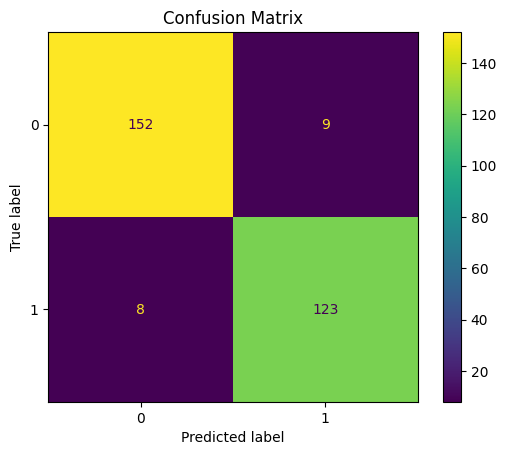

In [20]:
# 8. Visualisasi Confusion Matrix
ConfusionMatrixDisplay(confusion_matrix(y_val, y_pred)).plot()
plt.title("Confusion Matrix")
plt.show()

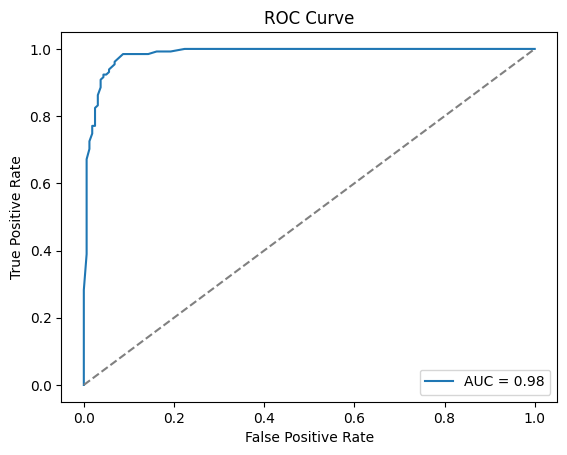

In [21]:
# 9. ROC Curve
fpr, tpr, _ = roc_curve(y_val, y_proba)
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


## Penjelasan Evaluasi

### Akurasi
Akurasi mengukur proporsi prediksi yang benar dari seluruh prediksi.
$$
Accuracy = \frac{TP + TN}{TP + TN + FP + FN}
$$

### Presisi
Presisi mengukur dari semua prediksi positif, berapa yang benar-benar positif.
$$
Precision = \frac{TP}{TP + FP}
$$

### Recall
Recall mengukur dari semua data positif, berapa yang berhasil diprediksi benar.
$$
Recall = \frac{TP}{TP + FN}
$$

### F1 Score
F1 Score adalah harmonic mean dari Presisi dan Recall.
$$
F1 = 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}
$$

### AUC (Area Under Curve)
AUC mengukur kemampuan model membedakan antara kelas positif dan negatif.

## Kesimpulan
Model Random Forest memberikan performa klasifikasi yang sangat baik dengan metrik sebagai berikut:
- **Akurasi**: 94.18%
- **Presisi**: 92.54%
- **Recall**: 94.66%
- **F1 Score**: 93.58%
- **AUC ROC**: 98.52%

Model ini efektif dalam memprediksi apakah rumah termasuk kategori "mahal" atau "murah" relatif terhadap median harga di dataset.
